# Commodity term structure

This notebook analyses commodity term structure strategy which utilises commodity futures' roll yield. The strategy takes long positions on contracts with most backwardation and short positions on ones with most contango. This idea is analogous to FX carry trade and hence this strategy can be classified as commodity carry trade.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_hollstein2020
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy
from vivace.backtest.stats import Performance

# Data

26 commodity futures are used as per Hollstein 2020.

In [2]:
all_futures_hollstein2020

,name
ticker,
CO,Brent Crude Oil
CC,Cocoa
KC,Coffee
C,Corn
CT,Cotton
FC,Feeder Cattle
GC,Gold
HO,Heating Oil
HG,Copper


In [3]:
all_futures_hollstein2020.shape

(26, 1)

# Performance

## Run backtest

Bakshi et al., 2017 used second front contracts and treated first front contracts as 'spot'. This is implemented by specifiying `nth_expiry=2` in this backtest. Term structure (i.e., carry) is then calculated by

$$
Carry_t = {\rm log} \left( \frac{F_{1, t}}{F_{2, t}} \right) \cdot annualisationFactor
$$

where $F_{1, t}$ is the 1st contract price, $F_{2, t}$ is the 2nd contract price and $annualisationFactor$ is the constant to make the log return annual while considering contract listing schedules for each commodity.

Hollstein 2020 uses trailing 1 year average of $Carry$ to avoid an influence of seasonality. The `SMA` post processing takes care of it. Signals are observed on a monthly basis and reflected to the portfolio by taking long  (short) positions for top (bottom) 33% contracts.

As typically the case in many studies about cross-sectional strategies, these commodity futures are equally weighted. However in practice some are much less liquid compared to major ones like crude oil. Some liquidity constraints need to be added to run more realistic analysis.

In [4]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_hollstein2020.index,
    signal=signal.XSCarryFutureFuture(nth_expiry_shift=1, 
                                      post_process=processing.Pipeline([
                                          processing.SMA(252),
                                          processing.AsFreq(freq='m', method='pad')
                                      ])),
    log_level=logging.WARN,
)
engine.run()

In [5]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False)
                    .rename('Commodity term structure portfolio'))

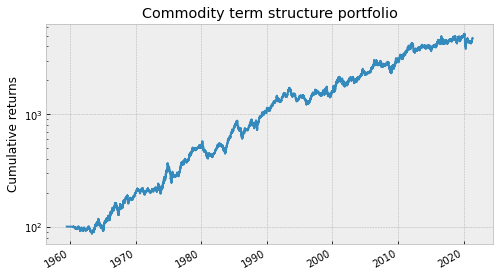

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('Commodity term structure portfolio')
ax.set_ylabel('Cumulative returns');

In [7]:
portfolio_return.pipe(Performance).summary()

,Commodity term structure portfolio
annualised return,0.067903
annualised vol,0.113231
Sharpe ratio,0.599686
max drawdown,0.335821
Calmar ratio,0.202200
skewness,-0.133943
kurtosis,2.573031
worst return,-0.073517
worst 1d return,-0.073517
worst 1w return,-0.094895


## Recent performance

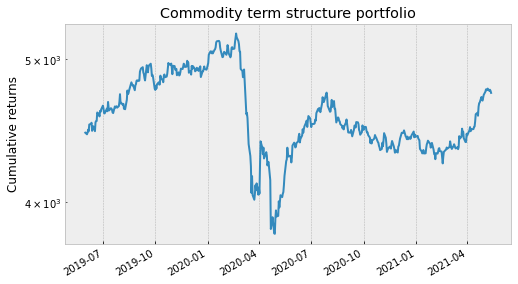

In [8]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('Commodity term structure portfolio')
ax.set_ylabel('Cumulative returns');

## Carry

The chart below shows the current annualised carry (1y average) across contracts.

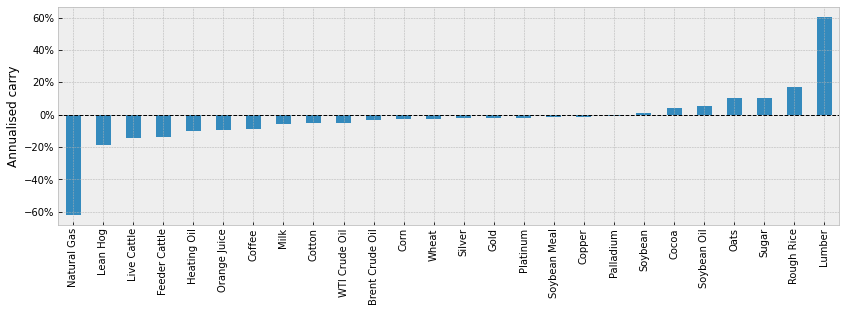

In [9]:
fig, ax = plt.subplots(figsize=(14, 4))
(engine.pipeline.pipeline[0].carry.rolling(252).mean().asfreq('m', method='pad').tail(1).squeeze().sort_values()
 .rename(index=all_futures_hollstein2020.squeeze())
 .plot(kind='bar', ax=ax));
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.axhline(0, color='black', lw=1, ls='--')
ax.set_ylabel('Annualised carry');

Carry for natural gas tends to have extreme values in winter.

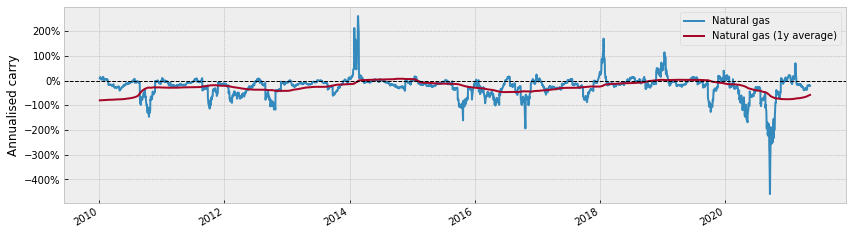

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
engine.pipeline.pipeline[0].carry.loc['2010':, 'NG'].plot(ax=ax, label='Natural gas');
engine.pipeline.pipeline[0].carry.rolling(252).mean().loc['2010':, 'NG'].plot(ax=ax, label='Natural gas (1y average)');
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.axhline(0, color='black', lw=1, ls='--')
ax.legend();
ax.set_ylabel('Annualised carry');

## Without carry smoothening

The carry smoothening does not seem critical when constructing a portfolio. In fact, the portfolio without carry smoothening had higher volatility and Sharpe ratio, although recently it suffered a larger drawdown.

In [11]:
engine_wo_sma = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_hollstein2020.index,
    signal=signal.XSCarryFutureFuture(nth_expiry_shift=1, 
                                      post_process=processing.Pipeline([
                                          processing.AsFreq(freq='m', method='pad')
                                      ])),
    log_level=logging.WARN,
)
engine_wo_sma.run()

In [12]:
portfolio_return_wo_sma = (engine_wo_sma.calculate_equity_curve(calculate_net=False)
                           .rename('Commodity term structure portfolio (w/o carry smoothening)'))

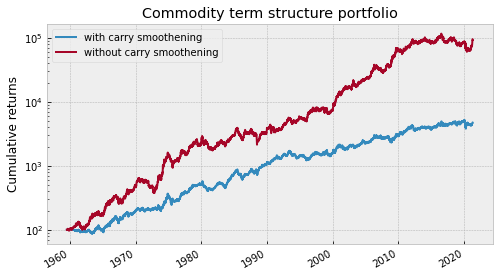

In [13]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True, label='with carry smoothening');
portfolio_return_wo_sma.plot(ax=ax, logy=True, label='without carry smoothening');
ax.set_title('Commodity term structure portfolio')
ax.set_ylabel('Cumulative returns')
ax.legend();

In [14]:
pd.concat((
    portfolio_return.pipe(Performance).summary(),
    portfolio_return_wo_sma.pipe(Performance).summary(),
), axis=1)

,Commodity term structure portfolio,Commodity term structure portfolio (w/o carry smoothening)
annualised return,0.067903,0.121859
annualised vol,0.113231,0.161296
Sharpe ratio,0.599686,0.755503
max drawdown,0.335821,0.473483
Calmar ratio,0.202200,0.257367
skewness,-0.133943,-0.050040
kurtosis,2.573031,5.326814
worst return,-0.073517,-0.140873
worst 1d return,-0.073517,-0.140873
worst 1w return,-0.094895,-0.125046


# Reference
- Bakshi, G., Gao, X. and Rossi, A.G., 2019. Understanding the sources of risk underlying the cross section of commodity returns. Management Science, 65(2), pp.619-641.
- Hollstein, F., Prokopczuk, M. and Tharann, B., 2020. Anomalies in commodity futures markets: Risk or mispricing?. Available at SSRN.
- Koijen, R.S., Moskowitz, T.J., Pedersen, L.H. and Vrugt, E.B., 2018. Carry. Journal of Financial Economics, 127(2), pp.197-225.

In [15]:
print(f'Updated: {datetime.utcnow().strftime("%d-%b-%Y %H:%M")}')

Updated: 14-May-2021 07:11
